# Make intended "Figure 1" for spectral ice paper

### Jonah Shaw, 09/20/2021

Four panels (potentially more) with contour plots of observed monthly trends  
1. dT/dt (GISStemp or HadCrut?)  
2. Ice extent trend (need to find gridded monthly product)
3. CERES ASR (03/2000 - 02/2020 or 01/2001 - 01/2020)
4. CERES OLR (03/2000 - 02/2020 or 01/2001 - 01/2020)

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load datasets

CERES, GISStemp, HadSST, NSIDC

## Load GISStemp data

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [2]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [3]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [4]:
giss_tsel = giss1.sel(time=slice('2000-03','2021-03'))['air']

In [5]:
giss1.close()

## Load HadSST3.1 data

Haven't used this before, but trying to find something with temperature records from the Arctic.

In [6]:
hadsst_path = '/glade/work/jonahshaw/obs/HadSST3.0/'
hadsst_file = 'HadSST.3.1.1.0.median.nc'

In [7]:
hadsst = xr.open_dataset('%s/%s' % (hadsst_path,hadsst_file))['sst']

## Load NSIDC data

Using the G10010 V2 product for now.

The ancilliary data has the lat/lon point for each gridcell

In [8]:
g10010_path = '/glade/work/jonahshaw/obs/NSIDC/G10010_V2/'
g10010_file = 'G10010_sibt1850_v2.0.nc'

In [9]:
nsidc_seaice = xr.open_dataset('%s/%s' % (g10010_path,g10010_file))

Using the G02202 V4 product (recommended by Walt Meier)

In [10]:
g02202_path = '/glade/work/jonahshaw/obs/NSIDC/G02202_V4/'

In [11]:
g02202_files = glob.glob('%s*.nc' % (g02202_path))
g02202_files.sort()

In [12]:
g02202_ancilliary = xr.open_dataset(g02202_files[0])
g02202_test = xr.open_dataset(g02202_files[1])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nsidc_bt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nsidc_nt_seaice_conc_monthly' has _Unsigne

In [19]:
g02202_test['cdr_seaice_conc_monthly'][0]

<xarray.DataArray 'cdr_seaice_conc_monthly' (y: 448, x: 304)>
array([[0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       [0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       [0.  , 0.  , 0.  , ..., 2.54, 2.54, 2.54],
       ...,
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ],
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ],
       [2.54, 2.54, 2.54, ..., 0.  , 0.  , 0.  ]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2000-01-01
    xgrid    (x) float32 -3837500.0 -3812500.0 ... 3712500.0 3737500.0
    ygrid    (y) float32 5837500.0 5812500.0 5787500.0 ... -5312500.0 -5337500.0
Dimensions without coordinates: y, x
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    valid_range:          [  0 100]

This is wack

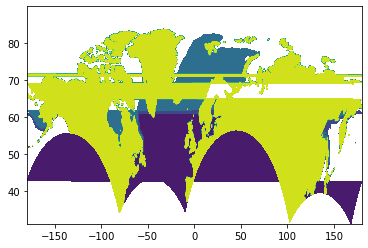

In [23]:
plt.contourf(g02202_ancilliary['longitude'],g02202_ancilliary['latitude'],g02202_test['cdr_seaice_conc_monthly'][0])

## Load CERES data

I am using files from Brian Medeiros (most recent, somehow processed)

In [26]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)

In [27]:
# Loaded save timeseries or process them from Brian Medeiros' monthly data
if os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
    ceres_asr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)
    
if os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
    ceres_olr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)

if (not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)) or (not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)):    
    all_ceres = xr.open_mfdataset(ceres_files)
    
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
        ceres_asr = all_ceres['solar_mon'] - all_ceres['toa_sw_all_mon']
        
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
        ceres_olr = all_ceres['toa_lw_all_mon']

## Define function for computing trends

#### Old function that relies on xarray implementing polyfit

In [36]:
# If I figure out apply_ufunc I could get rid of the loop over months...
def lat_trends_monthly(ds):
    '''
    Returns a (lat,month) dataarray with the linear trend slope for each gridcell.
    Makes use of the xarray.polyfit vectorized function.
    '''
    
    # keep shape and dims for output
#     empty = ds.mean(dim='lon').groupby('time.month').mean('time').copy()
    empty = xr.zeros_like(ds.mean(dim=['lon']).groupby('time.month').mean('time'))
#     print(empty.shape)
        
    month_groups = ds.mean(dim='lon').groupby('time.month')
    
    for i,grp in month_groups:
        _month_tseries = grp.groupby('time.year').mean(dim='time') # Create a timeseries over years
        
        try:
            _spat_trend = _month_tseries.polyfit(dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)
        except: # set output as nans if the call fails
            print('polyfit failed for month #%d' % i)
            blank_shape = empty[i-1,:,:].shape
            _spat_trend = np.nan * np.zeros(blank_shape)

        # Handle unloaded dask arrays (done by JupyterHub automatically?)
        try:
            empty.load() # probably not worth the computation
        except:
            pass
        empty[i-1,:] = _spat_trend

#     empty.name = empty.name + '_trend'
    return empty

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [28]:
def linregress1d_np(data, times):
#     print(f"data: {data.shape} | x: {times.shape}") # different formatting syntax
    return stats.linregress(times, data)

In [29]:
def vectorized_linregress(data):
    '''
    Package for my vectorized linregress call. Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
    linregress1d_np,  # first the function
    data,  # now arguments in the order expected by 'regress1_np'
    data.year,
    input_core_dims=[["year"], ["year"],],
    output_core_dims= [[] for _ in range(5)],
    exclude_dims=set(("year",)),
    vectorize=True,
    dask="parallelized",
    output_dtypes=[data.dtype for _ in range(5)], # one per output
    )
    
    return regressed_month

## Calculate trends and statistical significance

#### CERES ASR

In [92]:
# Subset data so computations are lighter and significance tests make sense
ceres_asr_subset = ceres_asr['ASR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [93]:
# create empty arrays for needed output
asr_trends = xr.zeros_like(ceres_asr_subset.groupby('time.month').mean('time'))
asr_rvalues = asr_trends.copy()
asr_pvalues = asr_trends.copy()

# Potentially I should be able to format this to avoid this for loop too
for i,_month in ceres_asr_subset.groupby('time.month'):
    
    _yearlydata = _month.groupby('time.year').mean('time')    
    regressed_month = vectorized_linregress(_yearlydata)
    
    ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
    asr_trends[ii] = regressed_month[0]
    asr_rvalues[ii] = regressed_month[2]
    asr_pvalues[ii] = regressed_month[3]

# Calculate statistical significance
N = len(_yearlydata.year)
dof=N-2

tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
t=asr_rvalues*np.sqrt(N-2)/np.sqrt((1-asr_rvalues*asr_rvalues))

statsig_asr=(1-asr_pvalues)*100

#### CERES OLR

In [94]:
# Subset data so computations are lighter and significance tests make sense
ceres_olr_subset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [95]:
# create empty arrays for needed output
olr_trends = xr.zeros_like(ceres_olr_subset.groupby('time.month').mean('time'))
olr_rvalues = olr_trends.copy()
olr_pvalues = olr_trends.copy()

# Potentially I should be able to format this to avoid this for loop too
for i,_month in ceres_olr_subset.groupby('time.month'):
    
    _yearlydata = _month.groupby('time.year').mean('time')
    regressed_month = vectorized_linregress(_yearlydata)
    
    ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
    olr_trends[ii] = regressed_month[0]
    olr_rvalues[ii] = regressed_month[2]
    olr_pvalues[ii] = regressed_month[3]
    
# Calculate statistical significance
N = len(_yearlydata.year)
dof = N - 2

tcrit = stats.t.ppf(0.975,dof)  ## two-sided 95%
t = olr_rvalues * np.sqrt(N - 2) / np.sqrt((1 - olr_rvalues * olr_rvalues))

statsig_olr = (1 - olr_pvalues) * 100 # student's two-tailed t-test
notnull_olr = t > tcrit # disproving the null hypothesis (slope is zero)

#### Temperature from GISStemp

In [100]:
# Subset data so computations are lighter and significance tests make sense
gisstemp_subset = giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)).mean('lon')

In [101]:
# create empty arrays for needed output
gisstemp_trends = xr.zeros_like(gisstemp_subset.groupby('time.month').mean('time'))
gisstemp_rvalues = gisstemp_trends.copy()
gisstemp_pvalues = gisstemp_trends.copy()

# Potentially I should be able to format this to avoid this for loop too
for i,_month in gisstemp_subset.groupby('time.month'):
    
    _yearlydata = _month.groupby('time.year').mean('time')
    regressed_month = vectorized_linregress(_yearlydata)
    
    ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
    gisstemp_trends[ii] = regressed_month[0]
    gisstemp_rvalues[ii] = regressed_month[2]
    gisstemp_pvalues[ii] = regressed_month[3]

# Calculate statistical significance
N = len(_yearlydata.year)
dof = N - 2

tcrit = stats.t.ppf(0.975,dof)  ## two-sided 95%
t = gisstemp_rvalues * np.sqrt(N - 2) / np.sqrt((1 - gisstemp_rvalues * gisstemp_rvalues))

statsig_gisstemp = (1 - gisstemp_pvalues) * 100 # student's two-tailed t-test
notnull_gisstemp = t > tcrit # disproving the null hypothesis (slope is zero)

#### Ice Concentration from NSIDC G10010

In [133]:
try:
    nsidc_seaice = nsidc_seaice.rename({'latitude':'lat','longitude':'lon'})
except:
    pass

# Subset by time and latitude
g10010_tsel = nsidc_seaice.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(90,59))

# Need to perform a masked and weighted average because areas are not constant and land cells must be masked
g10010_subset = masked_average(g10010_tsel['seaice_conc'],dim=['lon'],
                                      weights=g10010_tsel['Gridcell_Area'],mask=(g10010_tsel['LandRegion_mask']==20))

In [138]:
# create empty arrays for needed output
g10010_trends = xr.zeros_like(g10010_subset.groupby('time.month').mean('time'))
g10010_rvalues = g10010_trends.copy()
g10010_pvalues = g10010_trends.copy()

# Potentially I should be able to format this to avoid this for loop too
for i,_month in g10010_subset.groupby('time.month'):
    
    _yearlydata = _month.groupby('time.year').mean('time')
    regressed_month = vectorized_linregress(_yearlydata)
    
    ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
    g10010_trends[ii] = regressed_month[0]
    g10010_rvalues[ii] = regressed_month[2]
    g10010_pvalues[ii] = regressed_month[3]
    
# Calculate statistical significance
N = len(_yearlydata.year)
dof = N - 2

tcrit = stats.t.ppf(0.975,dof)  ## two-sided 95%
t = g10010_rvalues * np.sqrt(N - 2) / np.sqrt((1 - g10010_rvalues * g10010_rvalues))

statsig_g10010 = (1 - g10010_pvalues) * 100 # student's two-tailed t-test
notnull_g10010 = t > tcrit # disproving the null hypothesis (slope is zero)

## Compute trends for the different variables of interest

__Temperature from GISStemp.__

In [37]:
gisstemp_trange = giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)) # latitude is in the wrong order

gisstemp_trends = lat_trends_monthly(gisstemp_trange)
# gisstemp_trends = lat_trends_monthly(gisstemp_trange.where(gisstemp_trange['lat']>58))
                                

__Temperature from HadSST. (not working yet)__

In [17]:
hadsst = hadsst.rename({'latitude':'lat','longitude':'lon'})

hadsst_trange = hadsst.sel(time=slice('2001-01-01','2020-12-31'))

hadsst_trends = lat_trends_monthly(hadsst_trange.where(hadsst_trange['lat']>58))

polyfit failed for month #1


IndexError: too many indices

__Ice Concentration from NSIDC G10010.__

In [38]:
try:
    nsidc_seaice = nsidc_seaice.rename({'latitude':'lat','longitude':'lon'})
except:
    pass
nsidc_seaice_trange = nsidc_seaice.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(90,59))

landmask = nsidc_seaice_trange['LandRegion_mask']==20

nsidc_seaice_masked = nsidc_seaice_trange['seaice_conc'].where(~landmask)

nsidc_seaice_trends = lat_trends_monthly(nsidc_seaice_masked)

### Plot summary data

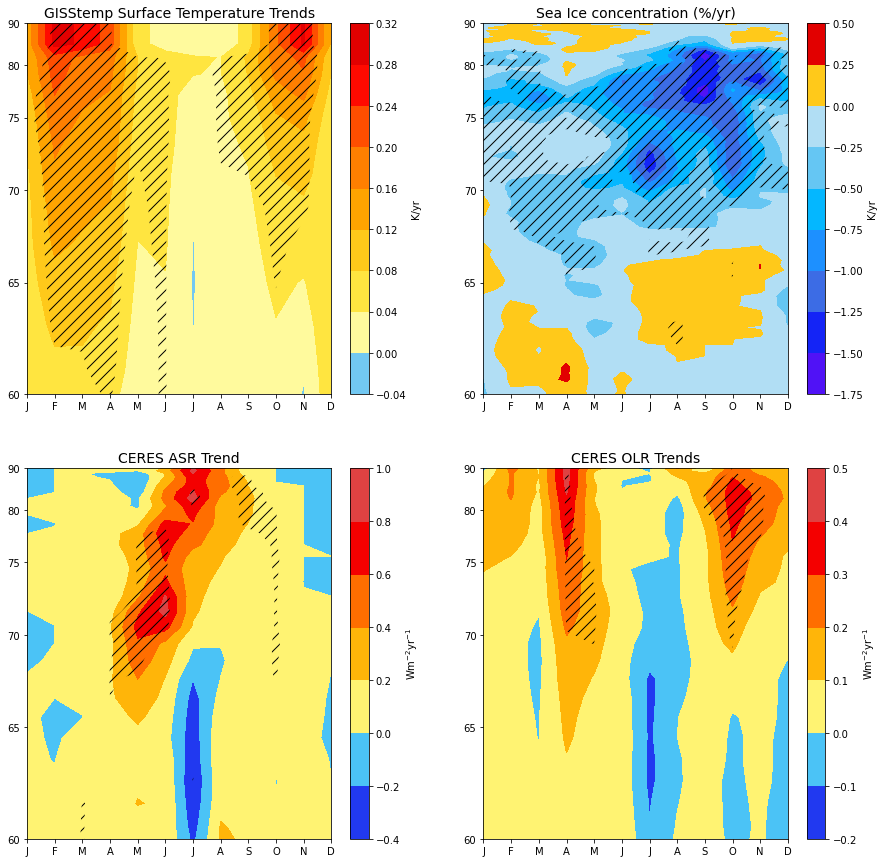

In [147]:
fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
xticks = np.arange(1,12.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)
    
lat_weighted0 = np.sin(np.pi/180*gisstemp_trends['lat'])
im0 = axes[0].contourf(gisstemp_trends['month'],lat_weighted0,gisstemp_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-0.1,vmax=0.4))
stip = axes[0].contourf(statsig_gisstemp['month'],lat_weighted0,statsig_gisstemp.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('GISStemp Surface Temperature Trends',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='K/yr')

lat_weighted1 = np.sin(np.pi/180*g10010_trends['lat'])
im1 = axes[1].contourf(g10010_trends['month'],lat_weighted1,g10010_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-1.75,vmax=0.5))
stip = axes[1].contourf(g10010_trends['month'],lat_weighted1,statsig_g10010.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('Sea Ice concentration (%/yr)',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='%/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends['lat'])
im2 = axes[2].contourf(asr_trends['month'],lat_weighted2,asr_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-0.4,vmax=1.0))#,levels=np.arange(-1.0,1.01,0.2))
stip = axes[2].contourf(statsig_asr['month'],lat_weighted2,statsig_asr.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends['lat'])
im3 = axes[3].contourf(olr_trends['month'],lat_weighted3,olr_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-0.2,vmax=0.5),levels=np.arange(-0.2,0.51,0.1))
stip = axes[3].contourf(statsig_olr['month'],lat_weighted3,statsig_olr.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')


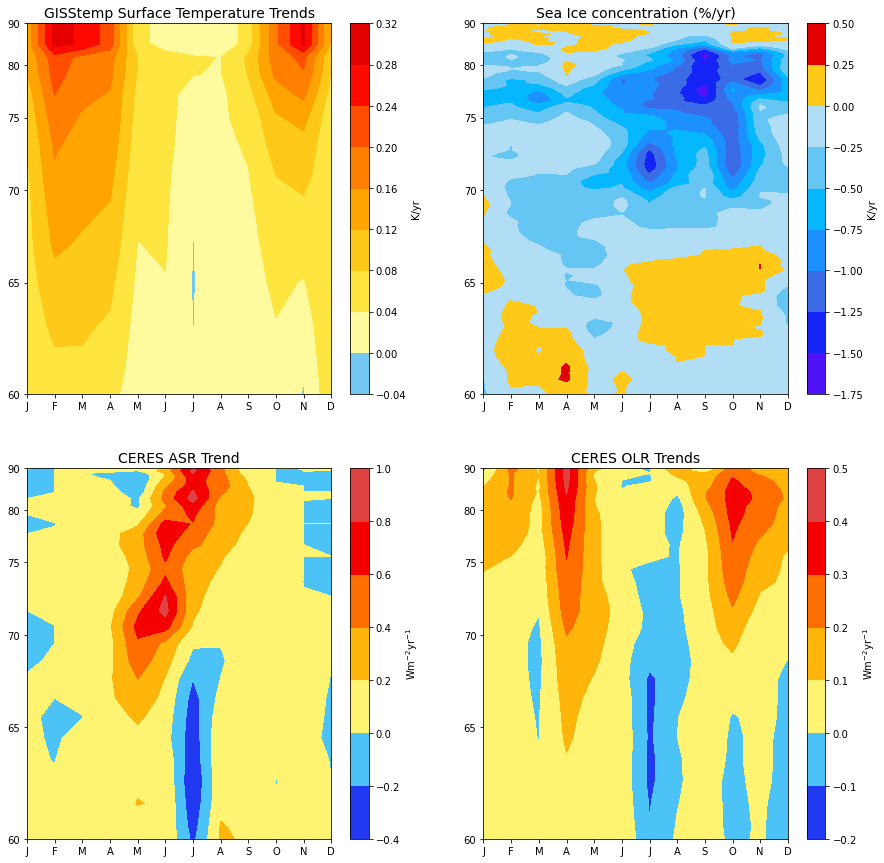

In [22]:
fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
xticks = np.arange(1,12.01,1)

for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)
    
lat_weighted0 = np.sin(np.pi/180*gisstemp_trends['lat'])
im0 = axes[0].contourf(gisstemp_trends['month'],lat_weighted0,gisstemp_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-0.1,vmax=0.4))
axes[0].set_title('GISStemp Surface Temperature Trends',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='K/yr')

lat_weighted1 = np.sin(np.pi/180*nsidc_seaice_trends['lat'])
im1 = axes[1].contourf(nsidc_seaice_trends['month'],lat_weighted1,nsidc_seaice_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-1.75,vmax=0.5))#,levels=np.arange(-2,2.01,0.5))
axes[1].set_title('Sea Ice concentration (%/yr)',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*ceres_asr_trends['lat'])
im2 = axes[2].contourf(ceres_asr_trends['month'],lat_weighted2,ceres_asr_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-0.4,vmax=1.0))#,levels=np.arange(-1.0,1.01,0.2))
stip = axes[2].contourf(statsig_asr['lon'],statsig_asr['lat'],statsig_asr, colors='none',levels=[0,90,95,100],
                        hatches=[None,'.','//'],extend='neither')

axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*ceres_olr_trends['lat'])
im3 = axes[3].contourf(ceres_olr_trends['month'],lat_weighted3,ceres_olr_trends.transpose('lat','month'),
                       cmap=cmaps.ncl_default,norm=MidpointNormalize(midpoint=0,vmin=-0.2,vmax=0.5),levels=np.arange(-0.2,0.51,0.1))
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')


In [34]:
for i in ceres_asr['ASR'].groupby('time.month'):
    break

In [38]:
ex_timeseries = i[1].groupby('time.year').mean(dim='time')

In [40]:
ex_timeseries.polyfit(dim='year',deg=1)

<xarray.Dataset>
Dimensions:               (degree: 2, lat: 180, lon: 360)
Coordinates:
  * degree                (degree) int64 1 0
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    polyfit_coefficients  (degree, lat, lon) float64 0.2268 0.2268 ... -0.049

In [42]:
ex_timeseries.isel(lat=0,lon=0)

<xarray.DataArray 'ASR' (year: 21)>
array([143.19998, 145.1    , 152.19998, 150.20001, 155.     , 144.29999,
       151.09998, 148.9    , 144.70001, 146.6    , 146.90002, 151.5    ,
       149.20001, 151.79999, 148.69998, 151.59998, 152.9    , 153.69998,
       148.69998, 150.9    , 152.1    ], dtype=float32)
Coordinates:
    lon      float32 0.5
    lat      float32 -89.5
  * year     (year) int64 2001 2002 2003 2004 2005 ... 2017 2018 2019 2020 2021

#### Create a wrapper function to start out

In [152]:
def linregress1d_np(data, times):
#     print(f"data: {data.shape} | x: {times.shape}") # different formatting syntax
    return stats.linregress(times, data)

regressed = linregress1d_np(ex_timeseries.isel(lat=0,lon=0), ex_timeseries.year)
# expected = air.interp(lat=newlat)

# no errors are raised if values are equal to within floating point precision
# np.testing.assert_allclose(expected.isel(time=0, lon=0).values, interped)

In [153]:
regressed

LinregressResult(slope=0.2267530168805804, intercept=-306.5098536900112, rvalue=0.4259254308593535, pvalue=0.05420896224867877, stderr=0.11050330404411056)

In [154]:
xr.apply_ufunc(
    linregress1d_np,  # first the function
    ex_timeseries.isel(lat=0,lon=0),  # now arguments in the order expected by 'interp1_np'
    ex_timeseries.year,
    input_core_dims=[["year"], ["year"],],
    exclude_dims=set(("year",)),
)

<xarray.DataArray ()>
array(LinregressResult(slope=0.2267530168805804, intercept=-306.5098536900112, rvalue=0.4259254308593535, pvalue=0.05420896224867877, stderr=0.11050330404411056),
      dtype=object)
Coordinates:
    lon      float32 0.5
    lat      float32 -89.5

In [155]:
regressed = xr.apply_ufunc(
    linregress1d_np,  # first the function
    ex_timeseries.isel(
        lat=slice(3),lon=slice(4)
    ),  # now arguments in the order expected by 'interp1_np'
    ex_timeseries.year,
    input_core_dims=[["year"], ["year"],],
    output_core_dims= [[] for _ in range(5)],
    exclude_dims=set(("year",)),
    vectorize=True
)

# interped["lat"] = newlat  # need to add this manually
# xr.testing.assert_allclose(expected.isel(time=0, lon=0), interped)


In [156]:
print(regressed[0].isel(lat=0,lon=0).values)
print(regressed[1].isel(lat=0,lon=0).values)
print(regressed[2].isel(lat=0,lon=0).values)
print(regressed[3].isel(lat=0,lon=0).values)
print(regressed[4].isel(lat=0,lon=0).values)

0.2267530168805804
-306.5098536900112
0.4259254308593535
0.05420896224867877
0.11050330404411056


In [157]:
slopes = regressed[0]
intercepts = regressed[0]
rvalues = regressed[0]
pvalues = regressed[0]
stderrs = regressed[0]

In [138]:
# %%timeit

regressed_test_slope = xr.apply_ufunc(
    linregress1d_slope_np,  # first the function
    ex_timeseries.chunk({"lat": 1, "lon": 1}),  # now arguments in the order expected by 'regress1_np'
    ex_timeseries.year,
    input_core_dims=[["year"], ["year"],],
#     output_core_dims= [[] for _ in range(5)],
    output_core_dims= [[]],
    exclude_dims=set(("year",)),
    vectorize=True,
    dask="parallelized",
#     output_dtypes=[ex_timeseries.dtype for _ in range(5)], # one per output
    output_dtypes=[ex_timeseries.dtype], # one per output
)

# interped["lat"] = newlat  # need to add this manually
# xr.testing.assert_allclose(expected.isel(time=0, lon=0), interped)


In [139]:
regressed_test_slope.compute()

<xarray.DataArray (lat: 180, lon: 360)>
array([[0.22675301, 0.22675301, 0.22675301, ..., 0.22675301, 0.22675301,
        0.22675301],
       [0.11636329, 0.11636329, 0.11636329, ..., 0.11636329, 0.11636329,
        0.11636329],
       [0.01999968, 0.01999968, 0.01999968, ..., 0.01999968, 0.01999968,
        0.01999968],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [127]:
regressed_test_slope

,Array,Chunk
Bytes,518.40 kB,8 B
Shape,"(180, 360)","(1, 1)"
Count,194402 Tasks,64800 Chunks
Type,float64,numpy.ndarray


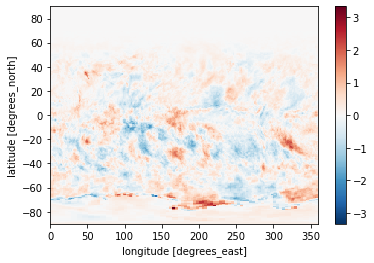

In [126]:
regressed_test_slope.plot()

In [114]:
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [119]:
%%timeit

# return a new DataArray
stats_out = xr.apply_ufunc(new_linregress, ex_timeseries, ex_timeseries.year,
                       input_core_dims=[['year'], ['year']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       output_sizes={"parameter": 5},
                      )

13.9 s ± 314 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:
stats_out

NameError: name 'stats_out' is not defined

In [105]:
%%timeit

regressed_test = xr.apply_ufunc(
    linregress1d_np,  # first the function
    ex_timeseries,  # now arguments in the order expected by 'regress1_np'
    ex_timeseries.year,
    input_core_dims=[["year"], ["year"],],
#     output_core_dims= [['slope'],['intercept'],['rvalue'],['pvalue'],['stderr']],
    output_core_dims= [[] for _ in range(5)],
    exclude_dims=set(("year",)),
    vectorize=True,
#     dask="parallelized",
#     output_dtypes=[ex_timeseries.dtype for _ in range(5)], # one per output
)

# interped["lat"] = newlat  # need to add this manually
# xr.testing.assert_allclose(expected.isel(time=0, lon=0), interped)


13.3 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
ex_timeseries.chunk({"lat": 1, "lon": 1})

,Array,Chunk
Bytes,5.44 MB,84 B
Shape,"(21, 180, 360)","(21, 1, 1)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
